### Background<sup>1</sup>
The Health Insurance Marketplace provides health insurance plan shopping and enrollment services<br>
for individuals and families as well as small business through websites, call centers,<br>
and in-person assistance.<br>

There are 10 Essential Health Benefits(EHB)that Marketplace plans must provide coverage for:<br>
* Ambulatory patient services(doctor visits and clinic visits)<br>
* Emergency services<br>
* Hospitalization<br>
* Maternity and newborn care<br>
* Mental health and substance use disorder services<br>
* Prescription drugs<br>
* Rehabilitative and habilitative services<br>
* Laboratory services<br>
* Preventive and wellness services and chronic disease management<br>
* Pediatric services<br>

Plans sold through the Marketplace are primarily separated into 4 health plan categories,<br>
(Bronze, Silver, Gold, and Platinum) based on the percentage the plan pays of the average <br>
overall cost of providing EHB to members. 
 
Health Plan Categories:
* Bronze level - health plan that has an Actuarial Value (AV) of 60 percent <br>
  consumers pay 40 percent of costs on average.
* Silver level - health plan that has an Actuarial Value (AV) of 70 percent<br>
  consumers pay 30 percent of costs on average.
* Gold level - health plan that has an Actuarial Value (AV) of 80 percent<br>
  consumers pay 20 percent of costs on average.
* Platinum level - health plan that has an Actuarial Value (AV) of 90 percent<br>
  consumers pay 10 percent of costs on average.   
  
### Eploration Ideas

Which plan category consumers choose affects the total amount they will likely spend<br>
for EHB during the year. Having an idea of the relationship between rates and various attributes can be<br>
benefical in purchasing health insurance. The analysis will focus on the following:<br>

* How plan rates and benefits vary across states.<br>
* How plan benefits relate to plan rates.<br>
* How plan rates vary by age.<br>
* How plans vary across insurance network providers.<br>

### Data Collection
The data is from the 2021 Exchange PUF Datasets of theCenters for Medicare and Medicaid Services.<br>
There are four datasets used in the analysis:<br>
* Benefits_Cost_Sharing_PUF.csv<br>
* Network_PUF.csv<br>
* Plan_Attributes_PUF.csv<br>
* Rate_PUF.csv<br>
The datasets can be found [here](https://www.cms.gov/cciio/resources/data-resources/marketplace-puf).<br>


### Data Cleaning and Pre-Analysis

Each dataset was subset to bring in only the features of interest for the analysis. Some exploratory data analysis was done prior to the analysis and can be seen in the CMS_DATA jupyter notebook located [here](https://github.com/kelenosi/Python-Data-Analysis-Project.git).

In the code blocks below tables are joined and some features are adjusted where necessary.<br>


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_bcs = pd.read_csv('Benefits_Cost_Sharing_PUF.csv', encoding="latin1", low_memory=False)
df_ntwrk = pd.read_csv('Network_PUF.csv', encoding="latin1", low_memory=False)
df_pattr = pd.read_csv('Plan_Attributes_PUF.csv', encoding="latin1", low_memory=False)
df_rate = pd.read_csv('Rate_PUF.csv', encoding="latin1", low_memory=False)


In [3]:
#benefit plan tables for joining

df_benefit = df_bcs.iloc[:,np.r_[1,2,6,7]].drop_duplicates()
df_benefit["PlanId"] = df_benefit["PlanId"].str[:14]

df_ben_cnt=df_benefit.groupby(["StateCode","IssuerId","PlanId"]).agg("count")["BenefitName"].reset_index()
df_ben_cnt.columns = df_ben_cnt.columns.str.replace('BenefitName','Benefit_Count')


In [4]:
#plan attribute table for joining--contains PlanType--(HMO,PPO, etc) and NetworkId

df_attr = df_pattr.iloc[:,np.r_[1,2,7,11,14,15,16,41]]

df_attr["PlanId"] = df_attr["PlanId"].str[:14]

df_attr_id=df_attr.iloc[:,np.r_[0,1,4,5,7]].drop_duplicates()


In [5]:
#network table for joining
df_nwk = df_ntwrk.iloc[:,np.r_[1,2,5,6,8]].drop_duplicates()


In [6]:
#rate tables: df_rate_age for graphing; 
#              df_rates for joining --drop "Family Option" from age level replace age end points convert to numeric/int
df_rate_age = df_rate.iloc[:,np.r_[1:3,6,7,10,11]]
mask=df_rate_age["Age"].isin(["Family Option"])
df_rate_age = df_rate_age[~mask]
df_rate_age["Age"].replace({'0-14':'14','64 and over':'64'}, inplace=True)
df_rate_age["Age"]= pd.to_numeric(df_rate_age["Age"])
df_rate_age = df_rate_age[df_rate_age.IndividualRate != 9999.00]
df_rate_id = df_rate_age[["StateCode","IssuerId","PlanId"]].drop_duplicates()
len(df_rate_age)
df_rates=df_rate_age.groupby(["StateCode","IssuerId","PlanId"]).mean("IndividualRate").reset_index()


In [7]:
#join tables for analysis  
df_attr_join=df_attr.merge(
    df_rate_age, how='left', on=["StateCode","IssuerId","PlanId"]
).merge(
    df_nwk, how="left",on=["StateCode","IssuerId","NetworkId"])


In [8]:
#join tables for analysis 
df_ben_join=df_benefit.merge(
    df_rates, how='left', on=["StateCode","IssuerId","PlanId"]
).merge(
    df_attr_id, how='left', on=["StateCode","IssuerId","PlanId"]
)

##### How do plan rates and benefits vary across states.

To answer the question if available benefits vary by state. A plot of the benefit count
by state was conducted. As benefits are delivered via provider networks analysis was done
to understand which provider networks have the largest service area. Rates vary by geography
it can be useful for consumers who are considering relocation to understand how a perspective
state compares nationally in terms of healthcare rates.

The results are shown below.

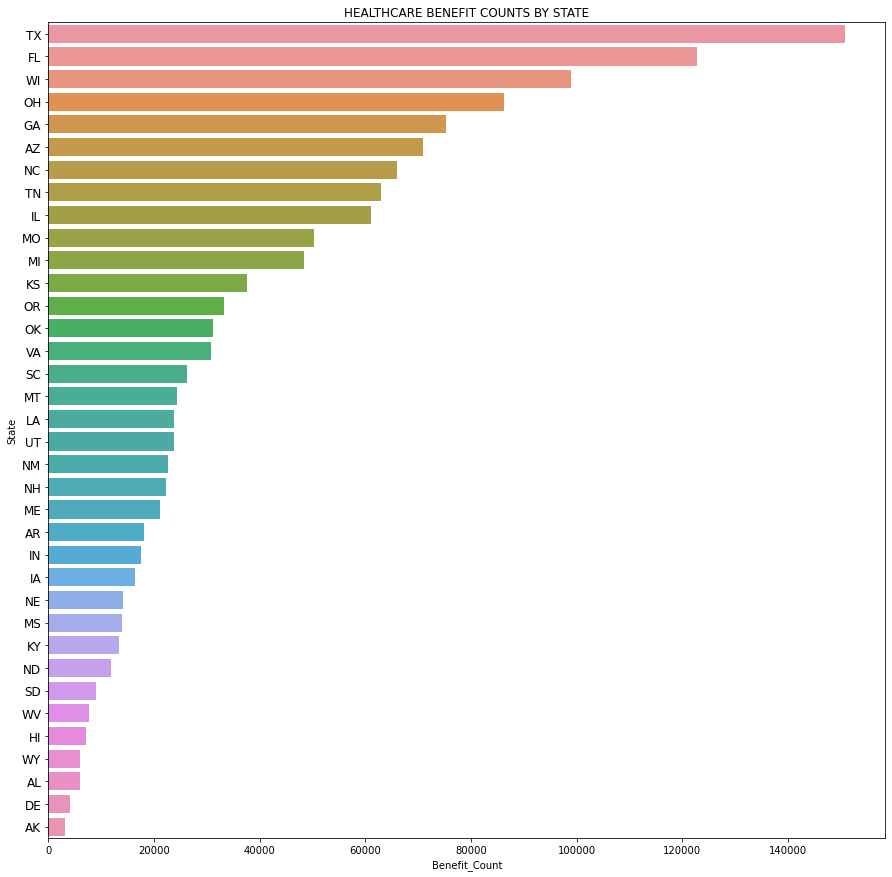

In [9]:
#Graph Benefit_Count by State
df_state_count =df_benefit.groupby("StateCode").agg("count")["BenefitName"].reset_index()
df_state_count.rename(columns={"StateCode":"State" ,"BenefitName":"Benefit_Count"}, inplace=True)
df_state_count = df_state_count.sort_values("Benefit_Count",ascending=False)

f, ax = plt.subplots(figsize=(15, 15)) 
ax.set_yticklabels(df_state_count.State, rotation='horizontal', fontsize='large')
plt.title("HEALTHCARE BENEFIT COUNTS BY STATE")
g = sns.barplot(y = df_state_count.State, x= df_state_count.Benefit_Count)
plt.show()

The graph above shows that Texas, Florida and Wisconsin are the states offering the most healthcare benefits.

In [10]:
#List of provider networks multi-state
df_prov_ntwrk = df_attr_join.groupby("NetworkName").StateCode.nunique().reset_index()
df_prov_ntwrk.rename(columns={"StateCode":"Number_Of_States" ,"NetworkName":"Name_Of_Network"}, inplace=True)
df_prov_ntwrk = df_prov_ntwrk.sort_values("Number_Of_States",ascending=False)
df_prov_ntwrk=df_prov_ntwrk[df_prov_ntwrk.Number_Of_States > 4].style.hide_index()
df_prov_ntwrk

Name_Of_Network,Number_Of_States
BEST Life and Health National Network,29
PDP PLUS,22
DentalGuard Preferred - Individual,18
Renaissance Dental,17
HumanaDental PPO/Traditional Preferred,15
Delta Dental PPO,14
DenteMax,13
DentalGuard Preferred,10
Dentegra PPO,9
Advantage,7


Table above illustrates health provider network saturation by state.

In [11]:
#State Map of Average Rates
df_state_rate = df_rate_age.groupby("StateCode").IndividualRate.mean().reset_index()
df_state_rate.rename(columns={"StateCode":"States" ,"IndividualRate":"Average_Rate"}, inplace=True)

data = dict(type = 'choropleth',
           locations = df_state_rate.States,
           locationmode = 'USA-states',
           colorscale = 'ylorrd', #
           text = df_state_rate.States,
           marker = dict (line = dict(color = 'rgb(255,255,255)',width=2)),
           z = df_state_rate.Average_Rate,
           colorbar = {'title':'Average Rate'})

layout = dict(title = '',
              geo=dict(scope = 'usa',showlakes = True,lakecolor='rgb(85,173,240)')) 

choromap2 = go.Figure(data = data,layout=layout)
choromap2.update_layout(
    title={
        'text': "Comparison of Individual Healthcare Rates Across States",
        'y':0.9,
        'x':0.4,
        'xanchor': 'center',
        'yanchor': 'top'})
iplot(choromap2)

A Choropleth plot can be used to visualize how plan rates vary across states.

##### How do plan benefits relate to plan rates.


Rates will vary by the type of benefit plan. Depending on the amount of flexibility provided in the plan, such
as whether out-of-network benefits are covered or if a referral from a consumer's primary care physician is 
required before they can see a specialist. In general broader more flexible plans are the most expensive.
The tables below illustrates the relationship between plan type, benefit type and insurance rates.

In [12]:
#Rates by plan type
df_plan_rate = df_attr_join.groupby(["PlanType"]).agg(
    {#"BenefitName": pd.Series.count, 
     "IndividualRate": pd.Series.mean}
).sort_values("IndividualRate",ascending=False).reset_index()

df_plan_rate[df_plan_rate.PlanType != "Indemnity"].round({'IndividualRate': 0}).style.hide_index()


PlanType,IndividualRate
POS,640.000000
EPO,605.000000
HMO,555.000000
PPO,248.000000


The table above shows how rates vary by plan type. In general we would expect a Preferred Provider Organization (PPO) plan to have the highest rates. A Health Maintenance Organization(HMO) plan is one of the cheapest types of health of insurance. Point of Service (POS)plans are similar to HMOs but with slightly higher rates. Further analysisshould be conducted to understand the reversals in rates from the expected relationship.

In [13]:
df_ben_rate=df_ben_join.groupby("BenefitName").agg("mean")["IndividualRate"].reset_index().sort_values(
    "IndividualRate",ascending=False)
df_top10 = df_ben_rate[0:10].round({'IndividualRate': 0}).style.hide_index()
df_top10

BenefitName,IndividualRate
Chronic Pain Treatment,821.000000
Adult Optical (hardware),707.000000
Non-Emergency Care When Traveling Outside the U.S.,700.000000
Bone Marrow Testing,660.000000
Substance Use Disorder Health Emergency Room,660.000000
Nutrition/Formulas,659.000000
Providence Phone/Video and Virtual Visits - Specialist,655.000000
Providence Phone/Video and Virtual Visits - Primary Care Provider (PCP),655.000000
"Congenital Anomaly, including Cleft Lip/Palate",653.000000
Osteoporosis,649.000000


The table above shows the 10 highest rates and the associated benefits.

In [14]:
df_bot10 = df_ben_rate.sort_values("IndividualRate").iloc[0:10].round({'IndividualRate': 0}).style.hide_index()
df_bot10

BenefitName,IndividualRate
Tissue Reline and Rebase,16.000000
Major Dental care - Adult HIGH Plan,16.000000
Major Dental Care- Adult High Plan,18.000000
Periodonatal Root Scaling and Planing,18.000000
Removal of Space Maintainers,18.000000
Implants,19.000000
Restorative Services,19.000000
Post and Core Build-up,19.000000
Tissue Conditioning,19.000000
Initial Placement of Bridges and Dentures,19.000000


The table above shows the 10 lowest rates and the associated benefits.

#####  How do plan rates vary by age.

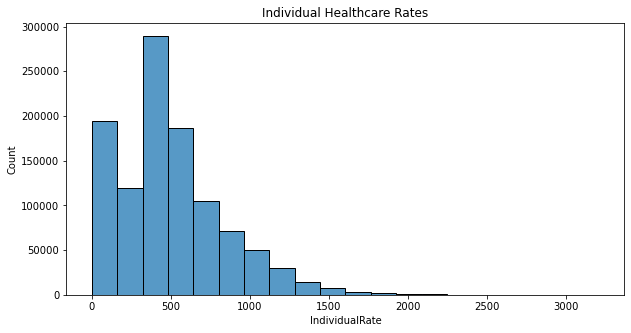

In [15]:
# Plot histogram
df_last_rate= df_rate_age[df_rate_age.RateExpirationDate == '2021-12-31' ].drop_duplicates()
plt.figure(figsize = (10,5))
ax=sns.histplot(df_last_rate['IndividualRate'], bins=20).set(title='Individual Healthcare Rates')


The chart above is a Histogram of the distribution of average healthcare rates.

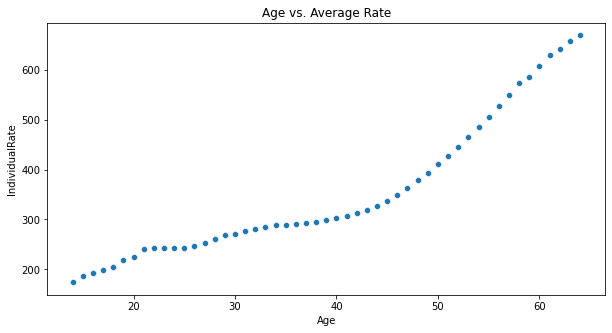

In [16]:
#Plot of average rates by age
df_rates=df_rate_age.iloc[:,4:6]
df_rates=df_rates.groupby("Age").agg('mean')["IndividualRate"].reset_index()
plt.figure(figsize = (10,5))
ax=sns.scatterplot(data=df_rates, x = "Age", y = "IndividualRate").set(title='Age vs. Average Rate')

Intuitively there should be a relationship between age and healthcare rates.
The above graph illustrates the linear relationship between age and rates. 

##### How do plans vary across insurance network providers.

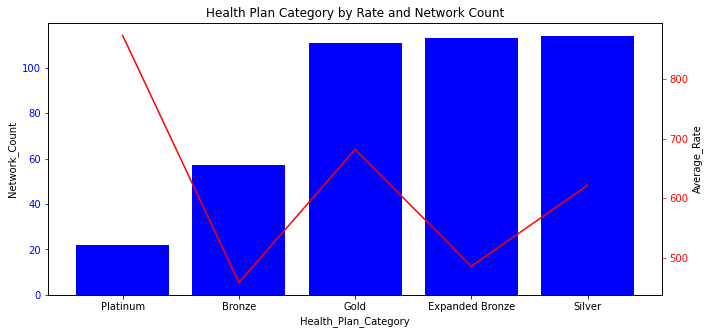

In [17]:
lvl=['High', 'Low', 'Catastrophic']

df_lvl_ntwrk=df_attr_join[~df_attr_join["MetalLevel"].isin(lvl)].groupby("MetalLevel").agg(
    {'NetworkId': pd.Series.nunique, 'IndividualRate': 'mean'}).sort_values("NetworkId").reset_index()

xs = df_lvl_ntwrk.iloc[:,0]  # x values
bar_ys = df_lvl_ntwrk.iloc[:,1]  # left y axis
line_ys_1 = df_lvl_ntwrk.iloc[:,2]  # right y axis


fig, bar_ax = plt.subplots(figsize=(11, 5))
bar_ax.set(title='Health Plan Category by Rate and Network Count')
bar_ax.bar(xs, bar_ys, color='blue')  # plot first y series (line)
bar_ax.set_xlabel('Health_Plan_Category')  # label for x axis
bar_ax.set_ylabel('Network_Count')  # label for left y axis
bar_ax.tick_params('y', colors='blue')  # add color to left y axis     
bar_ax.tick_params('x', labelrotation=0)  # add color to left y axis 

line_ax = bar_ax.twinx()
line_ax.plot(xs, line_ys_1, color='red')  # plot second y series (bar)
#line_ax.plot(xs, line_ys_2, color='green')  # plot second y series (bar)
#line_ax.plot(xs, line_ys_3, color='yellow')  # plot second y series (bar)
line_ax.set_ylabel('Average_Rate')  # label for right y axis
line_ax.tick_params('y',colors='red')
plt.show()

Chart above illustrates the relationship between the percent of EHB costs consumers pay  and the average rate charged. Plantinum health plans consumers out of pocket costs are low low deductibles and coinsurance. Consumers with Bronze health plans have higher deductibles and coinsurance but are charged a lower rate.

### Conclusion
There is considerable variation among health insurance plans in terms of the size of the provider network, the amount of benefits available, and the out of pocket expense consumers can expect to pay for receiving healthcare. Understanding the relationship between the rate charged and different attributes is a key step in deciding how to choose a health insurance plan.

<sup>1</sup>There are two source [files](https://github.com/kelenosi/Python-Data-Analysis-Project.git) used for the background section above:
* Marketplace 101.pptx 
* The Health Insurance Marketplace®.pdf<br>  
